# Discovery of Non-Linear Pendulum Dynamics using SODAs: Simulation vs Data

This notebook estimates the parameters of the heavily damped pendulum and plot the solution the discovered ODE against the video footage data.

In [3]:
import os, sys

path_to_add = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.append(path_to_add)
print(os.path.join(path_to_add, "daeFinder"))
sys.path.append(os.path.join(path_to_add, "daeFinder"))


import numpy as np
from scipy.integrate import odeint
import pandas as pd
import warnings
pd.set_option('display.float_format', '{:0.8f}'.format)
import operator
import sympy
from dae_finder import construct_reduced_fit_list

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp




from matplotlib import pyplot as plt
from dae_finder import smooth_data
from dae_finder import add_noise_to_df
from sklearn import decomposition
from sklearn.linear_model import LinearRegression
from dae_finder import get_simplified_equation_list
from dae_finder import get_refined_lib, remove_paranth_from_feat
from dae_finder import AlgModelFinder
from dae_finder import sequentialThLin, AlgModelFinder
from dae_finder import PolyFeatureMatrix
from copy import deepcopy



/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder


# Tracking from Pendulum video footage

- Run this section only once to get the (x,y) coordinates. 
- If this section is ran once, move to Loading of data directly.

## Loading data

In [4]:

# Loading pendulum data
df_list = []
for ind in [5,6,7,8,9]:
    file_path = f"data/pendulum_time_series_damped_{ind}.csv"
    df = pd.read_csv(file_path)
    df_list.append(df)

# trimming_slices=  [(10,200), (10,200), (10,200), (10,200), (10,200)]
trimming_slices=  [(10,1000), (10,1000), (10,1000), (10,1000)]

# trimming_slices=  [(10,-200), (10,-1), (10,-1), (10,-1), (10,-1)]


df_trimmed = []
for df_, slice in zip(df_list, trimming_slices):
    df_trimmed.append(df_[slice[0]:slice[1]].reset_index(drop=True))

#centering the hook of pendulum to origin
center = (947, 720)
color = [120, 255, 243]
for df_ in df_trimmed:
    df_["x"] = df_["X"] - center[0]
    df_["y"] = -(df_["Y"] - center[1])

# for i, df in enumerate(df_trimmed):
#     df.to_csv(f"data/trimmed_pendulum_time_series_damped_{i+1}.csv", index=False)

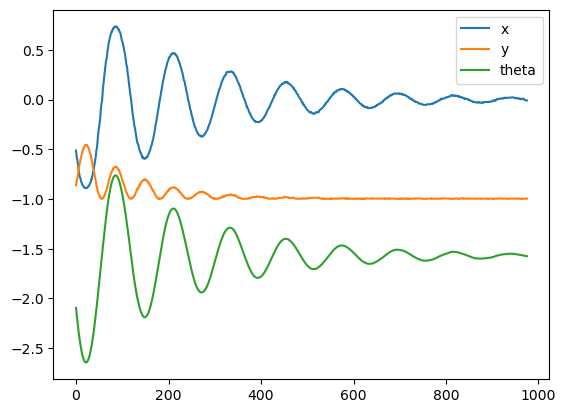

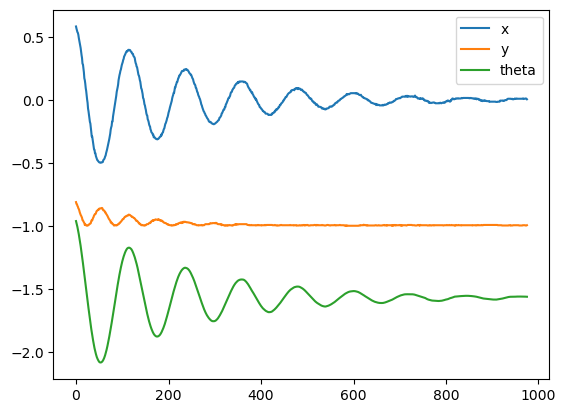

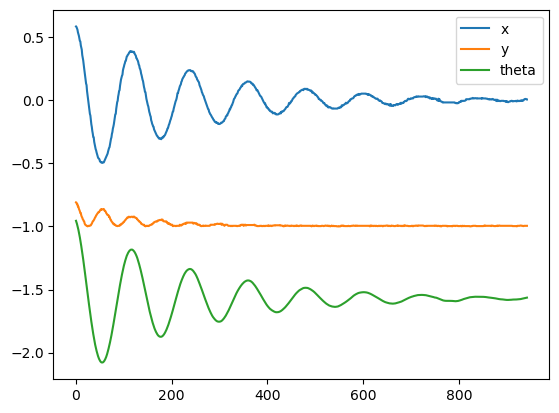

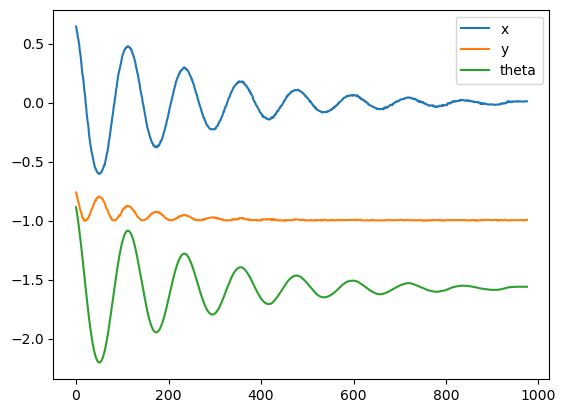

In [5]:
L=1    
smoothening_window_size = 15
pen_orig_len = abs(df_trimmed[0]["y"]).max()
#Scaling the pendulum length to L
for df_ in df_trimmed:
    df_["x"] = (df_["x"]/pen_orig_len) * L
    df_["y"] = (df_["y"]/pen_orig_len) * L

    # df_["x"] = df_["x"].rolling(window=smoothening_window_size, center=True).mean()
    # df_["y"] = df_["y"].rolling(window=smoothening_window_size, center=True).mean()

    # df_["theta"] = np.arctan2(df_["y"], df_["x"])
    df_["theta"] = (np.arctan2(df_["y"], df_["x"])).rolling(window=smoothening_window_size, center=True).mean()
    df_.dropna(ignore_index=True, inplace=True)

df_appended = pd.concat(df_trimmed, ignore_index=True)

for df_ in df_trimmed:
    df_[["x", "y", "theta"]].plot()


<Axes: >

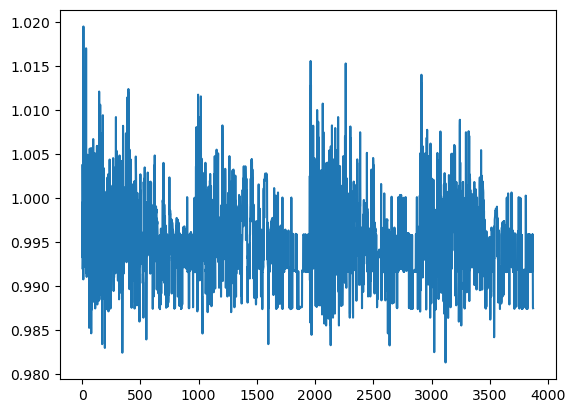

In [6]:
#Visualizing the algebraic constrain in the system
(df_appended["x"]**2+df_appended["y"]**2).plot()

### Finding the first and second order derivative of the states using Savitzky-Golay Filer

In [7]:
# Finding the first and second order derivative of the states using Savitzky-Golay Filer

data_matrix_smooth_df_list = [
    smooth_data(data_matrix,
                domain_var="t",
                smooth_method ="SG",
                noise_perc=0.1,
                derr_order=2,
                polyorder=2,
                window_smooth=None)[10:-10] #trimming zero derivatives near end points
    for data_matrix in df_trimmed]



if len(data_matrix_smooth_df_list) == 1:
    data_matrix_df_smooth_appended = data_matrix_smooth_df_list[0].reset_index(drop=True)
else:
    data_matrix_df_smooth_appended = pd.concat(data_matrix_smooth_df_list, ignore_index=True)

data_matrix_df_new= data_matrix_df_smooth_appended[["theta", "d(theta) /dt"]]


data_matrix_df_new = data_matrix_df_new.rename(columns= dict(zip(data_matrix_df_new, ['theta', 'theta_dot'])))

## Fomring the candidate library

In [8]:
import os, sys

path_to_add = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.append(path_to_add)
print(os.path.join(path_to_add, "daeFinder"))
sys.path.append(os.path.join(path_to_add, "daeFinder"))

poly_degree = 2
from daeFinder import PolyFeatureMatrix
poly_feature_ob = PolyFeatureMatrix(poly_degree)
candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_new)
# candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_smooth)





candidate_lib_full = candidate_lib_full.drop(["1"], axis=1)
print("Degree of library: {}".format(poly_degree))

#Optionally removing features from the library
terms_to_drop_corr = set()
candidate_lib_full = candidate_lib_full.drop(terms_to_drop_corr, axis=1)

#Adding sin and cos terms using x and y
candidate_lib_full["cos(theta)"] = data_matrix_df_smooth_appended["x"]
candidate_lib_full["sin(theta)"] = data_matrix_df_smooth_appended["y"]

print("Full candidate library has the following features: {}".format(candidate_lib_full.columns))
print("# terms in the library: {}".format(candidate_lib_full.shape[1]))



/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder
Degree of library: 2
Full candidate library has the following features: Index(['theta', 'theta_dot', 'theta^2', 'theta theta_dot', 'theta_dot^2',
       'cos(theta)', 'sin(theta)'],
      dtype='object')
# terms in the library: 7


## Finding the parameters from discovered ODE

In [ ]:
num_points = 300

data_matrix_smooth_df_list = [
    smooth_data(data_matrix[:num_points],
                domain_var="t",
                smooth_method ="SG",
                noise_perc=0.1,
                derr_order=2,
                polyorder=2,
                window_smooth=None)[10:-10] #trimming zero derivatives near end points
    for data_matrix in df_trimmed]



if len(data_matrix_smooth_df_list) == 1:
    data_matrix_df_smooth_appended = data_matrix_smooth_df_list[0].reset_index(drop=True)
else:
    data_matrix_df_smooth_appended = pd.concat(data_matrix_smooth_df_list, ignore_index=True)

data_matrix_df_new= data_matrix_df_smooth_appended[["theta", "d(theta) /dt", "x", "y"]]


data_matrix_df_new = data_matrix_df_new.rename(columns= dict(zip(data_matrix_df_new, ['theta', 'theta_dot', "x", "y"])))

from daeFinder import PolyFeatureMatrix
poly_feature_ob = PolyFeatureMatrix(poly_degree)
candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_new)
# candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_smooth)
candidate_lib_full = candidate_lib_full.drop(["1"], axis=1)
#Adding sin and cos terms using x and y
candidate_lib_full["cos(theta)"] = data_matrix_df_smooth_appended["x"]
candidate_lib_full["sin(theta)"] = data_matrix_df_smooth_appended["y"]

In [26]:

df_new_0 = df_trimmed[0][(df_trimmed[0]['x'].diff().abs() < 0.1) & (df_trimmed[0]['y'].diff().abs() < 0.1)][["t", "theta"]]
df_new_0 = df_new_0[9:]
omega0_0 = data_matrix_smooth_df_list[0]["d(theta) /dt"].iloc[0]

df_new_1 = df_trimmed[1][(df_trimmed[1]['x'].diff().abs() < 0.1) & (df_trimmed[1]['y'].diff().abs() < 0.1)][["t", "theta"]]
df_new_1 = df_new_1[9:]
omega0_1 = data_matrix_smooth_df_list[1]["d(theta) /dt"].iloc[0]


df_new_2 = df_trimmed[2][(df_trimmed[2]['x'].diff().abs() < 0.1) & (df_trimmed[2]['y'].diff().abs() < 0.1)][["t", "theta"]]
df_new_2 = df_new_2[9:]
omega0_2 = data_matrix_smooth_df_list[2]["d(theta) /dt"].iloc[0]

df_new_3 = df_trimmed[3][(df_trimmed[3]['x'].diff().abs() < 0.1) & (df_trimmed[3]['y'].diff().abs() < 0.1)][["t", "theta"]]
df_new_3 = df_new_3[9:]
omega0_3 = data_matrix_smooth_df_list[3]["d(theta) /dt"].iloc[0]

In [27]:
from scipy.optimize import curve_fit

def pendulum_rhs(t, y,beta, gamma, L=1):

    theta, omega = y
    alpha = beta * np.cos(theta) +  gamma * omega
    return [omega, alpha]


# Define the pendulum ODE function for curve fitting
def pendulum_ode_combined(t, beta, gamma):
    # Initial conditions for each dataset
    initial_conditions = [
        (df_new_0['theta'].iloc[0], omega0_0),
        (df_new_1['theta'].iloc[0], omega0_1),
        (df_new_2['theta'].iloc[0], omega0_2),
        (df_new_2['theta'].iloc[0], omega0_2)
    ]
    
    # Time values for each dataset
    t_values_list = [df_new_0['t'].values, df_new_1['t'].values, df_new_2['t'].values, df_new_3['t'].values]
    
    # Solve the ODE for each dataset and concatenate the results
    theta_values_combined = []
    for (theta0, omega0), t_values in zip(initial_conditions, t_values_list):
        y0 = [theta0, omega0]
        sol = solve_ivp(pendulum_rhs, [t_values[0], t_values[-1]], y0, t_eval=t_values, args=(beta, gamma))
        theta_values_combined.extend(sol.y[0])
    
    return np.array(theta_values_combined)

# Combine the theta values from all datasets
theta_values_combined = np.concatenate([df_new_0['theta'].values, df_new_1['theta'].values,
                                        df_new_2['theta'].values, df_new_3['theta'].values])

# Combine the time values from all datasets
t_values_combined = np.concatenate([df_new_0['t'].values, df_new_1['t'].values,
                                    df_new_2['t'].values, df_new_3['t'].values])

# Define initial guesses for beta and gamma
initial_guesses = [
    [-6.5, -3],
    [-10, -5],
    [-5, -2],
    [-8, -4],
    [-10, -10],
    [-5, 0],
    [0, -5],
    [5, 5],
    [-18, 1],
    [-15, -15],
]

best_params = None
best_rss = np.inf

# Perform curve fitting with different initial guesses
for initial_guess in initial_guesses:
    params, params_covariance = curve_fit(pendulum_ode_combined, t_values_combined, theta_values_combined, p0=initial_guess, maxfev=1000)
    beta_est, gamma_est = params
    
    # Calculate the residual sum of squares (RSS)
    theta_fitted = pendulum_ode_combined(t_values_combined, beta_est, gamma_est)
    rss = np.sum((theta_values_combined - theta_fitted) ** 2)
    
    # Update the best parameters if the current RSS is lower
    if rss < best_rss:
        best_rss = rss
        best_params = params

beta_est, gamma_est = best_params
print(f"Best estimated beta: {beta_est}")
print(f"Best estimated gamma: {gamma_est}")
print(f"Best RSS: {best_rss}")

Best estimated beta: -9.730547851354403
Best estimated gamma: -0.47332760795431233
Best RSS: 2.652181362161591


### Best estimates found

Best estimated beta: -9.730547851354403  
Best estimated gamma: -0.47332760795431233  
Best RSS: 2.652181362161591  

In [28]:
# num_points = 500
# Function to compute derivatives
num_points = 400

def pendulum_rhs(t, y,beta, gamma, L=1):

    theta, omega = y
    alpha = beta * np.cos(theta) +  gamma * omega
    return [omega, alpha]

# Parameters
theta0 = candidate_lib_full["theta"][0] 
omega0 = candidate_lib_full["theta_dot"][0]   


# theta0 = df_trimmed[0]["theta"][10]
# omega0 = -1.45531698   
# beta = dict(zip(lin_model.feature_names_in_, lin_model.coef_))["cos(theta)"]  
# gamma = dict(zip(lin_model.feature_names_in_, lin_model.coef_))["theta_dot"]     
# # 

# beta = -9.81
# gamma = -0.5
#   # Damping coefficient
L = 1.0             # Length of the pendulum (meters)
# t_span = (df_trimmed[0]["t"][10], df_appended["t"][num_points])
# t_eval = df_trimmed[0]["t"][10:num_points]   

t_span = (df_trimmed[0]["t"][10], df_appended["t"][num_points])
t_eval = df_trimmed[0]["t"][10:num_points]   
# t_span = (candidate_lib_full["t"][0], candidate_lib_full["t"][num_points])
# t_eval = candidate_lib_full["t"][1:num_points-1]   


sol = solve_ivp(lambda t, y: pendulum_rhs(t, y, beta_est, gamma_est, L), t_span, [theta0, omega0], t_eval=t_eval, rtol=1e-8)
        
sol_df = pd.DataFrame(sol.y.T, columns=["theta", "omega"])
sol_df["x"] = L*np.cos(sol_df["theta"])
sol_df["y"] = L*np.sin(sol_df["theta"])
sol_df["t"] = t_eval

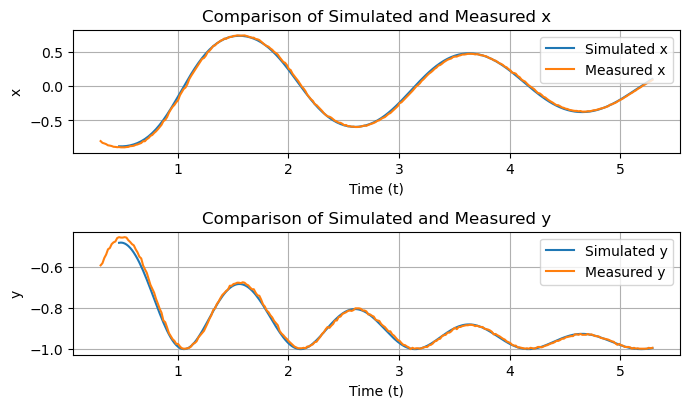

In [ ]:
num_points = 300
plt.figure(figsize=(7, 6))
lag =10 #adjustment for trimming dtheta/dt while smoothening
# Plot x
plt.subplot(3, 1, 2)
plt.plot(sol_df["t"][:num_points], sol_df["x"][:num_points], label='Simulated x')
# plt.plot(df_trimmed[0]["t"][lag:num_points], df_trimmed[0]["x"][lag:num_points], label='Measured x')
plt.plot(df_trimmed[0]["t"][:num_points], df_trimmed[0]["x"][lag:lag+num_points], label='Measured x')

# plt.plot(df_trimmed[0]["t"][lag:num_points], candidate_lib_full["x"][0:num_points], label='Measured x')

plt.xlabel('Time (t)')
plt.ylabel('x')
plt.legend()
plt.title('Comparison of Simulated and Measured x')
plt.grid(True)

# Plot y
plt.subplot(3, 1, 3)
plt.plot(sol_df["t"][:num_points], sol_df["y"][:num_points], label='Simulated y')
plt.plot(df_appended["t"][:num_points], df_appended["y"][lag:lag+num_points], label='Measured y')
plt.xlabel('Time (t)')
plt.ylabel('y')
plt.legend()
plt.title('Comparison of Simulated and Measured y')
plt.grid(True)

plt.tight_layout()
plt.show()

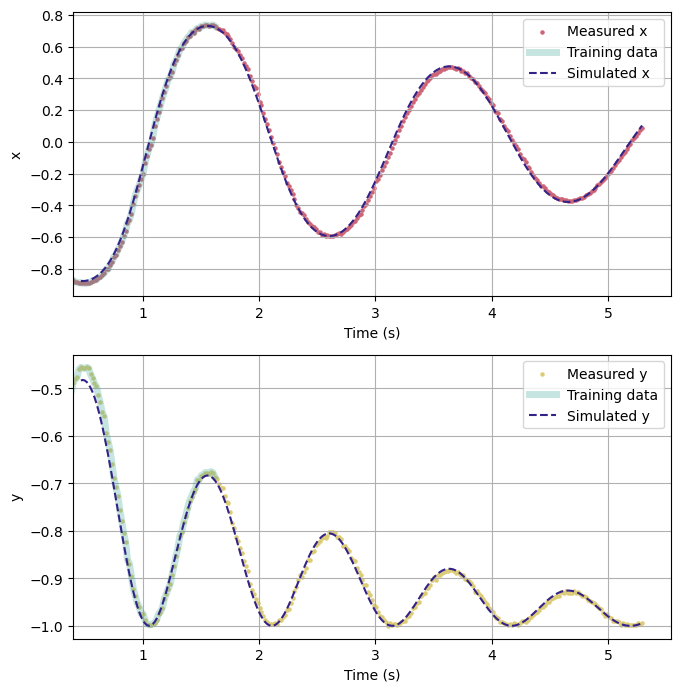

In [85]:
num_points = 300
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7, 7))
lag = 10  # adjustment for trimming dtheta/dt while smoothening
training_num = 80


# Plot x
axes[0].scatter(df_appended["t"][:num_points:1], df_appended["x"][lag:lag+num_points:1], label='Measured x', color='#CC6677', s=5)
axes[0].plot(df_appended["t"][:training_num], df_appended["x"][lag:lag+training_num], label='Training data', color='#44AA99', linewidth=5, alpha=0.3)
axes[0].plot(sol_df["t"][:num_points], sol_df["x"][:num_points], label='Simulated x', color='#332288', linestyle='--')

axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('x')
axes[0].legend()
axes[0].set_xlim(left=.4)

axes[0].grid(True)

# Plot y
axes[1].scatter(df_appended["t"][:num_points:1], df_appended["y"][lag:lag+num_points:1], label='Measured y', color='#DDCC77', s=5)
axes[1].plot(df_appended["t"][:training_num], df_appended["y"][lag:lag+training_num], label='Training data', color='#44AA99', linewidth=5, alpha=0.3)
axes[1].plot(sol_df["t"][:num_points], sol_df["y"][:num_points], label='Simulated y', color='#332288', linestyle='--')

axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('y')
axes[1].legend()

axes[1].set_xlim(left=.4)
axes[1].grid(True)

plt.tight_layout()
plt.savefig('Example_2_damped_pend_prediction.svg', format='svg')
plt.show()



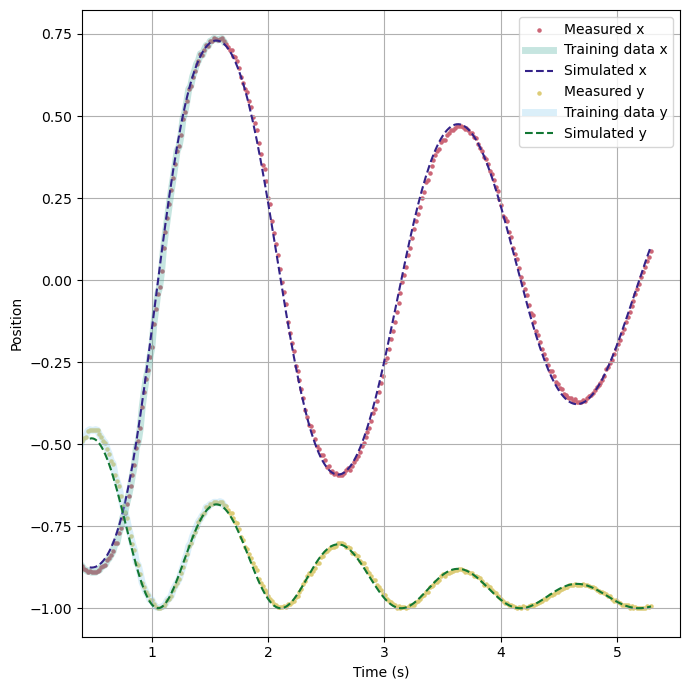

In [89]:
num_points = 300
fig, ax = plt.subplots(figsize=(7, 7))
lag = 10  # adjustment for trimming dtheta/dt while smoothening
training_num = 80

# Plot x
ax.scatter(df_appended["t"][:num_points:1], df_appended["x"][lag:lag+num_points:1], label='Measured x', color='#CC6677', s=5)
ax.plot(df_appended["t"][:training_num], df_appended["x"][lag:lag+training_num], label='Training data x', color='#44AA99', linewidth=5, alpha=0.3)
ax.plot(sol_df["t"][:num_points], sol_df["x"][:num_points], label='Simulated x', color='#332288', linestyle='--')

# Plot y
ax.scatter(df_appended["t"][:num_points:1], df_appended["y"][lag:lag+num_points:1], label='Measured y', color='#DDCC77', s=5)
ax.plot(df_appended["t"][:training_num], df_appended["y"][lag:lag+training_num], label='Training data y', color='#88CCEE', linewidth=5, alpha=0.3)
ax.plot(sol_df["t"][:num_points], sol_df["y"][:num_points], label='Simulated y', color='#117733', linestyle='--')

ax.set_xlabel('Time (s)')
ax.set_ylabel('Position')
ax.legend()
ax.set_xlim(left=.4)
ax.grid(True)

plt.tight_layout()
plt.savefig('Example_2_damped_pend_prediction.svg', format='svg')
plt.show()


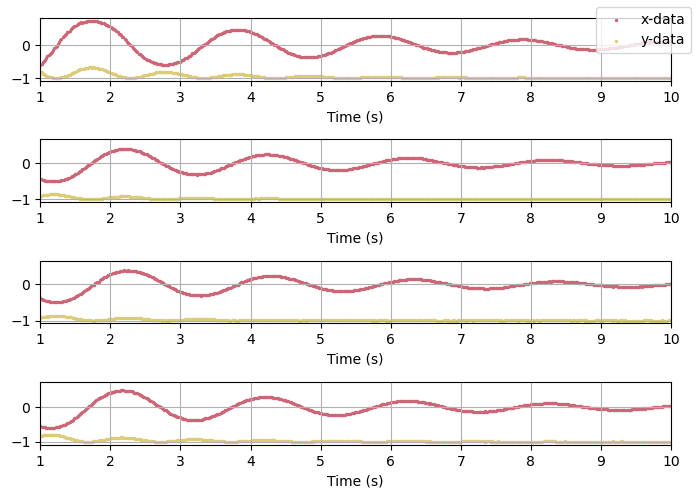

In [68]:
fig, axes = plt.subplots(len(df_trimmed), 1, figsize=(7, 5))

for i, df in enumerate(df_trimmed):
    df_subset = df[(df['t'] >= 0.2) & (df['t'] <= 10)]
    
    axes[i].scatter(df_subset['t'], df_subset['x'], label='x-data', s=2, color='#CC6677')
    axes[i].scatter(df_subset['t'], df_subset['y'], label='y-data', s=2, color='#DDCC77')
    axes[i].set_xlabel('Time (s)')
    axes[i].grid(True)  
    axes[i].set_xlim(left=1)  
    axes[i].set_xlim(right=10)  


handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

plt.tight_layout()

plt.savefig('Example_2_damped_pendulum_data.svg', format='svg')
plt.show()

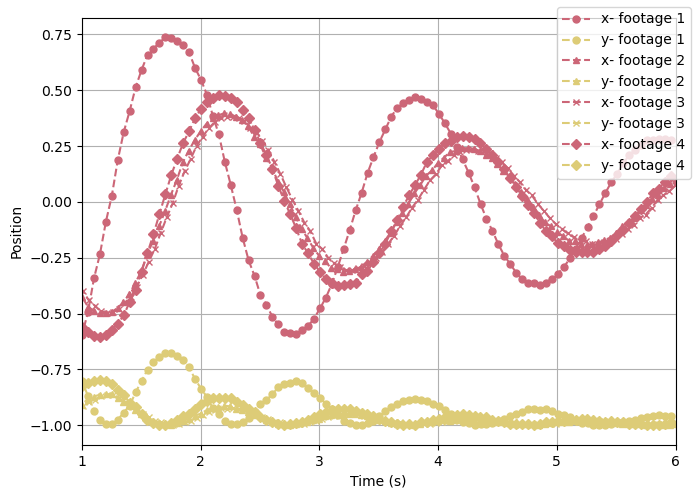

In [86]:
fig, ax = plt.subplots(figsize=(7, 5))
marker_list = ['o', '^', 'x', 'D']
label_list = ['footage 1', 'footage 2', 'footage 3', 'footage 4']

for i, df in enumerate(df_trimmed):
    df_subset = df[(df['t'] >= 0.2) & (df['t'] <= 6)]
    
    ax.plot(df_subset['t'][::3], df_subset['x'][::3], label=f'x- footage {i+1}', marker=marker_list[i % len(marker_list)],
             linestyle='--', color='#CC6677', markersize=5)
    ax.plot(df_subset['t'][::3], df_subset['y'][::3], label=f'y- footage {i+1}', marker=marker_list[i % len(marker_list)],
             linestyle='--', color='#DDCC77', markersize=5)

ax.set_xlabel('Time (s)')
ax.set_ylabel('Position')
ax.grid(True)
ax.set_xlim(left=1, right=6)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

plt.tight_layout()
plt.savefig('Example_2_damped_pendulum_data.svg', format='svg')
plt.show()         
